In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.callbacks import TensorBoard

import multiprocessing
from multiprocessing import Pool
from functools import partial

%matplotlib inline

#define function list to get each layer output
get_layer_output_functions = []
# for i in range(len(model.layers)):
#     get_layer_output_functions.append(K.function(model.layers[0].input,model.layers[i].output))

#function to get activation of input data into a list
def get_activation(data): 
    layer_output = []
    for f in get_layer_output_functions[:-1]:
        layer_output.append(f(data.reshape(1,2))[0])

    for i in range(len(layer_output)):
        #layer_nonzero_index = np.flatnonzero(layer_output[i])
        layer_output[i][np.flatnonzero(layer_output[i])] = 1
        layer_output[i] = layer_output[i].astype(int)
        
    act_list = layer_output
    return act_list

#assign a different color to each different activation,use color index
def assign_color(activations,act_index):
    color_index = 0
    for i in range(len(hid_layer_units)):
        binary = ''.join(str(e) for e in activations[act_index][i].astype(int))
        color_index+=int(binary,2)
    return color_index

def prepare_model(hid_layer_units):
    model = tf.keras.Sequential()
    for i in range(len(hid_layer_units)):
        if i == 0:
            model.add(Dense(hid_layer_units[i], input_shape=(2,), activation='relu',bias_initializer='random_uniform'))
        else:
            model.add(Dense(hid_layer_units[i], activation='relu',bias_initializer='random_uniform'))
    model.add(Dense(2, activation='softmax',bias_initializer='random_uniform'))
    # Configure a model for categorical classification.
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=[tf.keras.metrics.categorical_accuracy])
    return model

def data_grid(grid, square_len):
    k = square_len
    x = np.linspace(-k,k,grid+1)
    y = np.linspace(-k,k,grid+1) 

    xv,yv = np.meshgrid( x , y )
    data = np.array([xv.flatten(),yv.flatten()])
    data = data.transpose()
    return data

def get_color(hid_layer_units):
    interval = int(np.ceil(255/2**(np.sum(hid_layer_units)/3.0)))
    R = range(0,255,interval)
    G = range(0,255,interval)
    B = range(0,255,interval)
    rv,gv,bv = np.meshgrid(R,G,B)
    colors = np.array([rv.flatten(),gv.flatten(),bv.flatten()]).transpose()
    np.random.shuffle(colors)
    return colors

def draw_activation_and_prediction(num_epoch, colors, plot_style, X_test, model):
    pool = Pool(8)
    for i in range(num_epoch):
        print("epoch:{0}".format(i), end="\n")
        #loop for all data points to get activations
        i_data = 0
        activations = []

        for test_data in X_test:
            print("get activation progress:{0}%".format(round((i_data + 1) * 100 / len(X_test))), end='\r')
            activations.append(get_activation(test_data))
            i_data = i_data + 1
        print(end="\n")

        f = partial(assign_color,activations)

        i_color=0
        data_activation_color=[]
        for y in pool.map(f, range(len(activations))):
            i_color+=1
            print("get data color progress:{0}%".format(round((i_color + 1) * 100 / len(activations))), end="\r")
            data_activation_color.append(y)
        print(end="\n")

        data_activation_color = np.asarray(data_activation_color)
        if plot_style == style[1]:
            data_activation_color = colors[data_activation_color]/255
    #     data_activation_color = colors[]
    #     act_clusters = np.unique(data_activation_color)
    #     cluster_index = []
    #     for j in range(len(act_clusters)):
    #         cluster_index.append(np.where(data_activation_color == act_clusters[j]))

        plt.figure(figsize=(10, 10))
        plt.scatter(X_test[:, 0], X_test[:, 1], marker='o',s=4, c=data_activation_color, linewidths=2,cmap = 'gray')
        plt.savefig(directory+'/'+'epoch'+str(format(i,'0>3'))+'_'+model_name+'_activation')
        plt.title('epoch'+str(format(i,'0>3'))+'_'+model_name+'_activation')
        plt.close()

        Y_test = model.predict(X_test)
        plt.figure(figsize=(10, 10))
        intensity = [np.append(k*np.array([255,255]),0)/255.0 for k in Y_test]
        plt.scatter(X_test[:, 0], X_test[:, 1], marker='o',s=3, c=intensity, linewidths=1, label='Class 1')
        plt.title('epoch'+str(format(i,'0>3'))+'_'+model_name+'_predictProbility')
        plt.savefig(directory+'/'+'epoch'+str(format(i,'0>3'))+'_'+model_name+'_predictProbility')    
        plt.close()

        step = i+1
        model.fit(data, labels, epochs=1,steps_per_epoch=step,batch_size=int(N/800))

    pool.close()
    pool.join()

## Prepare Data

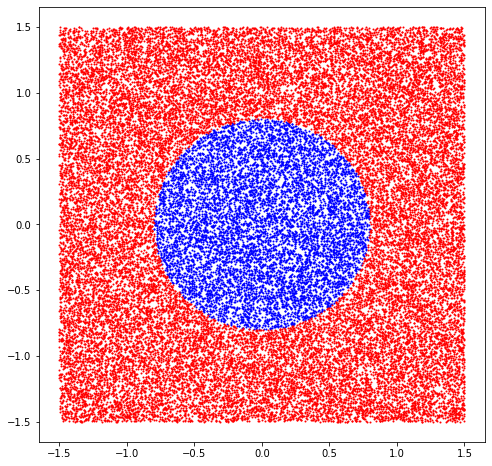

In [2]:
#Prepare data
N=40000
L=3
X = L*np.random.rand(N,2) 
X[:,0] = X[:,0]-L/2
X[:,1] = X[:,1]-L/2

Y = np.zeros([N,2])

for i in range(N):
    if (X[i,0])**2+(X[i,1])**2<0.64:
        Y[i,0]=1
    else:
        Y[i,1]=1

zero_class = np.where(Y[:, 0])
one_class = np.where(Y[:, 1])

plt.figure(figsize=(8, 8))
plt.scatter(X[zero_class, 0], X[zero_class, 1], s=1, facecolors='b', linewidths=1, label='Class 1')
plt.scatter(X[one_class, 0], X[one_class, 1], s=1, facecolors='r', linewidths=1, label='Class 2')
plt.show()

data = X
labels = Y

In [ ]:
import os
from tensorflow.keras import backend as K

hid_layer_units = [5, 4]
style = ['intensity_plot','color_plot']
plot_style = style[1]

# first_layer = [3,4,5,6,7,14,20,30]
# second_layer = [3,4,5,6,7,14,20,30]
first_layer = [6]
second_layer = [5]
num_epoch = 150
X_test = data_grid(grid=200,square_len=2)

for i in range(len(first_layer)):
    for j in range(len(second_layer)):
        print('hid_layer: [%i , %i]'%(first_layer[i],second_layer[j]))
        print('progress :', (i+j)/(len(first_layer)+len(second_layer)))
        hid_layer_units = [first_layer[i], second_layer[j]]
        model = prepare_model(hid_layer_units)
        
        model_name = '_'.join(str(e) for e in hid_layer_units)+'_2'+'_'+plot_style
        directory = 'iterasive_result/'+'model_'+model_name
        if not os.path.exists(directory):
            os.makedirs(directory)
        model.save(directory+'/'+'initial'+model_name+'_model.h5') 
        
        for i in range(len(model.layers)):
            get_layer_output_functions.append(K.function(model.layers[0].input,model.layers[i].output))
      
        colors = get_color(hid_layer_units)              
        draw_activation_and_prediction(num_epoch, colors, plot_style, X_test, model)

hid_layer: [6 , 5]
progress : 0.0
epoch:0
get activation progress:100%
get data color progress:100%


W0816 00:48:31.260091 140429869459264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1 samples
1/1 [==============================] - 0s 100ms/step - loss: 0.6488 - categorical_accuracy: 0.6806
epoch:1
get activation progress:100%
get data color progress:100%
Train on 2 samples
2/2 [==============================] - 0s 20ms/step - loss: 0.6460 - categorical_accuracy: 0.6852
epoch:2
get activation progress:100%
get data color progress:100%
Train on 3 samples
3/3 [==============================] - 0s 20ms/step - loss: 0.6415 - categorical_accuracy: 0.6935
epoch:3
get activation progress:100%
get data color progress:100%
Train on 4 samples
4/4 [==============================] - 0s 18ms/step - loss: 0.6351 - categorical_accuracy: 0.7053
epoch:4
get activation progress:100%
get data color progress:100%
Train on 5 samples
5/5 [==============================] - 0s 20ms/step - loss: 0.6268 - categorical_accuracy: 0.7187
epoch:5


In [141]:
# for i in range(100):
#     step = i+1
#     model.fit(data, labels, epochs=1,steps_per_epoch=step,batch_size=int(N/800),callbacks=[tensorboard])

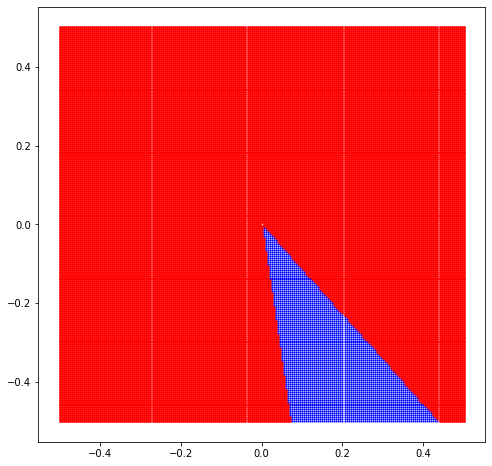

In [17]:
#test
import numpy as np

X_test = get_data_grid(200,0.5)
#np.random.shuffle(X_test)

Y_test = model.predict(X_test)
Y_test = np.rint(Y_test)

zero_class_test = np.where(Y_test[:, 0])
one_class_test = np.where(Y_test[:, 1])

plt.figure(figsize=(8, 8))
plt.scatter(X_test[zero_class_test, 0], X_test[zero_class_test, 1], marker='o',s=3, facecolors='r', linewidths=1, label='Class 1')
plt.scatter(X_test[one_class_test, 0], X_test[one_class_test, 1], marker='o', s=1, facecolors='b', linewidths=1, label='Class 2')
plt.show()
plt.savefig(directory+'/'+'test')
plt.close()

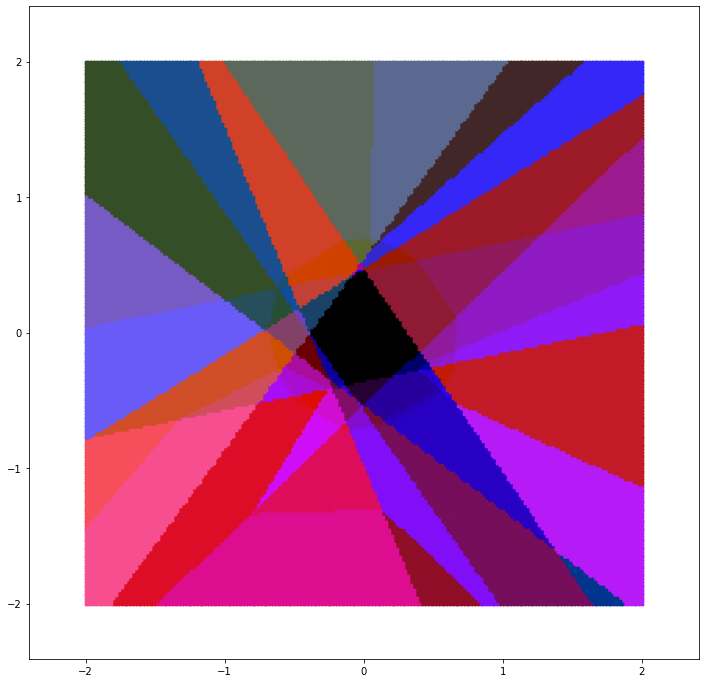

<Figure size 432x288 with 0 Axes>

In [47]:
progress = 0
plt.figure(figsize=(12, 12))
for k in range(len(cluster_index)):
    progress += 1
    #print("Progress:{0}%".format(round((progress + 1) * 100 / len(cluster_index))), end="\r")
    plt.scatter(X_test[cluster_index[k], 0], X_test[cluster_index[k], 1], marker='o',s=4, color=colors[data_activation_color[cluster_index[k]][0]]/255.0, linewidths=2)
plt.margins(x=0.1, y=0.1)
plt.show()
plt.savefig('activation')